In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage.morphology import disk, closing, opening, binary_opening
from skimage.measure import label
import soundfile as sf
from scipy.fft import fft, fftshift, fftfreq

## 1. Histogram-based processing

### Problem 1.1

In [2]:
def compute_CDF(image):
    counts, edges = np.histogram(image.flatten(), bins=256, range=(0, 256))  # compute histogram
    I_val = edges[:-1]  # intensity array
    CDF = np.cumsum(counts) / np.sum(counts)  # compute CDF and normalize
    return CDF, I_val

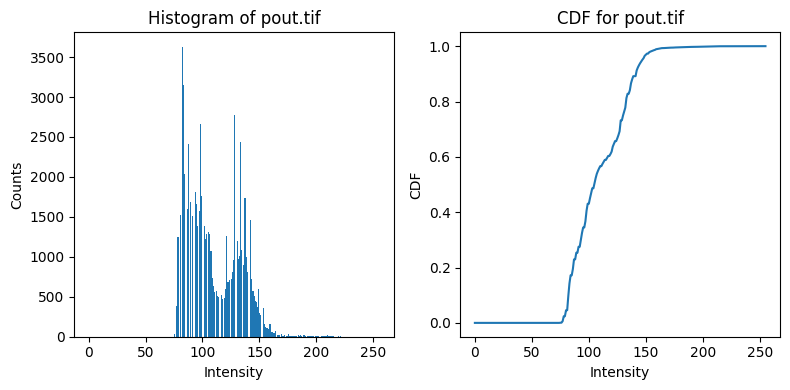

In [3]:
A = imread("pout.tif")

A_cdf, I_A = compute_CDF(A)

plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.hist(A.flatten(), bins=256, range=(0, 256))
plt.xlabel("Intensity")
plt.ylabel("Counts")
plt.title("Histogram of pout.tif")

plt.subplot(1, 2, 2)
plt.plot(I_A, A_cdf)
plt.xlabel("Intensity")
plt.ylabel("CDF")
plt.title("CDF for pout.tif")

plt.tight_layout()

### Problem 1.2

In [4]:
def CDF_image(image, CDF):
    return  CDF[image]  # returns image with intensity CDF(I(x,y)) for pixel at (x,y)

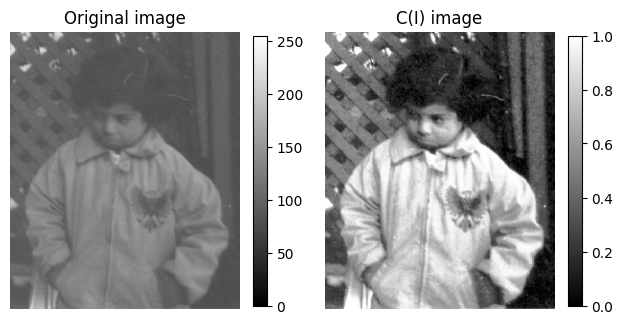

In [5]:
A_C_image = CDF_image(A, A_cdf)

plt.subplot(1, 2, 1)
plt.imshow(A, vmin=0, vmax=255, cmap="gray")
plt.colorbar(shrink=0.6)
plt.axis("off")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(A_C_image, vmin=0, vmax=1, cmap="gray")
plt.colorbar(shrink=0.6)
plt.axis("off")
plt.title("C(I) image")

plt.tight_layout()

### Problem 1.3

In [6]:
def pseudo_inverse(cdf):
    cdf_inv = np.empty_like(cdf)  # initialize array

    s_vals = np.linspace(0, 255, 256)
    l_vals = np.linspace(0, 1, 256)

    for i, l in enumerate(l_vals):  # compute pseudoinverse
        cdf_inv[i] = np.min(s_vals[np.where(cdf >= l)[0]])
    
    return cdf_inv, l_vals

Text(0, 0.5, '$C^{-1}$')

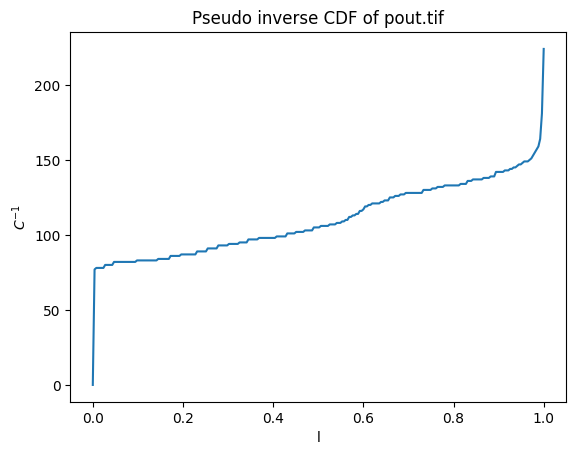

In [7]:
A_cdf_inv, A_l = pseudo_inverse(A_cdf)

plt.plot(A_l, A_cdf_inv)
plt.title("Pseudo inverse CDF of pout.tif")
plt.xlabel("l")
plt.ylabel(r"$C^{-1}$")

### Problem 1.4

In [8]:
def hist_match(image1, image2):
    C1, _ = compute_CDF(image1)  # compute CDF of original image
    C2, s2 = compute_CDF(image2)  # compute CDF of target image

    C1_image1 = CDF_image(image1, CDF=C1)  # compute C1(I1)

    C2_inv_C1_image1 = np.empty_like(C1_image1)  # initialize

    for i in range(C1_image1.shape[0]):  # compute C2^-1(C1(I1))
        for j in range(C1_image1.shape[1]):
            C2_inv_C1_image1[i, j] = np.min(s2[np.where(C2 >= C1_image1[i, j])[0]])

    return C2_inv_C1_image1

In [9]:
B = imread("rice.png")

A_hist_matched_to_B = hist_match(A, B)

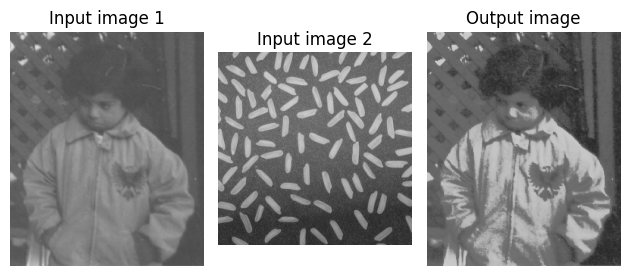

In [10]:
plt.subplot(1, 3, 1)
plt.imshow(A, vmin=0, vmax=255, cmap="gray")
plt.axis("off")
plt.title("Input image 1")

plt.subplot(1, 3, 2)
plt.imshow(B, vmin=0, vmax=255, cmap="gray")
plt.axis("off")
plt.title("Input image 2")

plt.subplot(1, 3, 3)
plt.imshow(A_hist_matched_to_B, vmin=0, vmax=255, cmap="gray")
plt.axis("off")
plt.title("Output image")

plt.tight_layout()

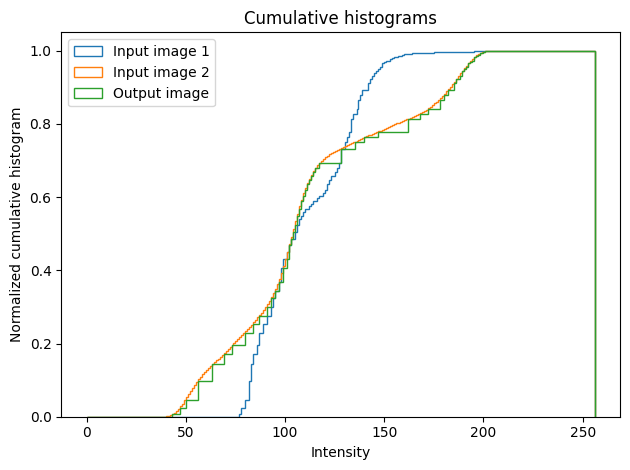

In [11]:
plt.hist(A.flatten(), bins=256, range=(0, 256), cumulative=True, density=True, histtype="step", label="Input image 1")
plt.hist(B.flatten(), bins=256, range=(0, 256), cumulative=True, density=True, histtype="step", label="Input image 2")
plt.hist(A_hist_matched_to_B.flatten(), bins=256, range=(0, 256), cumulative=True, density=True, histtype="step", label="Output image")
plt.xlabel("Intensity")
plt.ylabel("Normalized cumulative histogram")
plt.title("Cumulative histograms")
plt.legend()
plt.tight_layout()

## 2. Segmentation by thresholding

### Problem 2.1

In [12]:
def perform_thresholding(image, threshold=100/256):

    image_gray = rgb2gray(image)  # convert to gray-scale
    binary_image = np.where(image_gray <= threshold, 0, 1)  # perform thresholding
    
    return binary_image

In [13]:
C = imread("pillsect.png")
C_gray = rgb2gray(C)

C_thresholded = perform_thresholding(C)

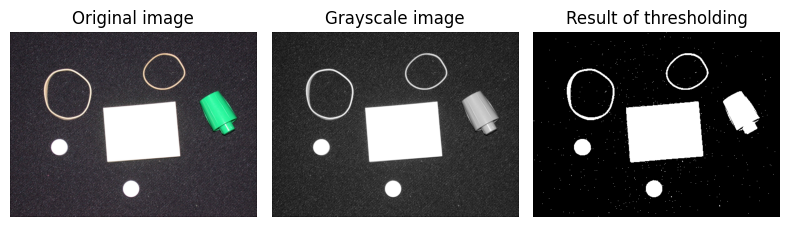

In [14]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.imshow(C)
plt.axis("off")
plt.title("Original image")

plt.subplot(1, 3, 2)
plt.imshow(C_gray, cmap="gray")
plt.axis("off")
plt.title("Grayscale image")

plt.subplot(1, 3, 3)
plt.imshow(C_thresholded, cmap="gray")
plt.axis("off")
plt.title("Result of thresholding")

plt.tight_layout()

### Problem 2.2

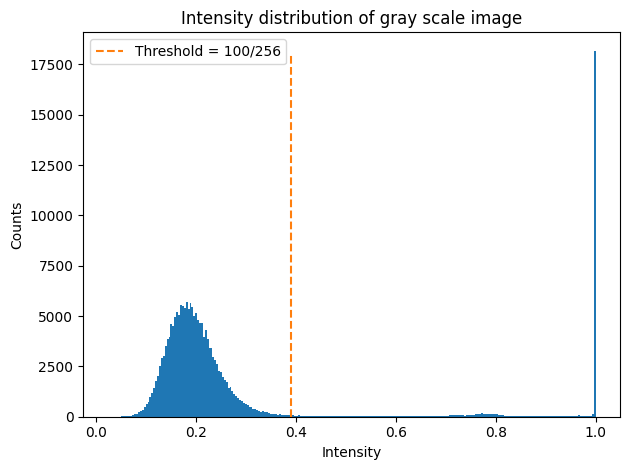

In [15]:
plt.hist(C_gray.flatten(), bins=256)
plt.plot((100/256, 100/256), (0, 18000), "--", label="Threshold = 100/256")
plt.title("Intensity distribution of gray scale image")
plt.xlabel("Intensity")
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()

## 3. Morphology

### Problem 3.1.1

In [16]:
D = imread("cells_binary_inv.png")
SE = disk(1)

In [17]:
D_opened = opening(D, SE)
D_closed = closing(D, SE)

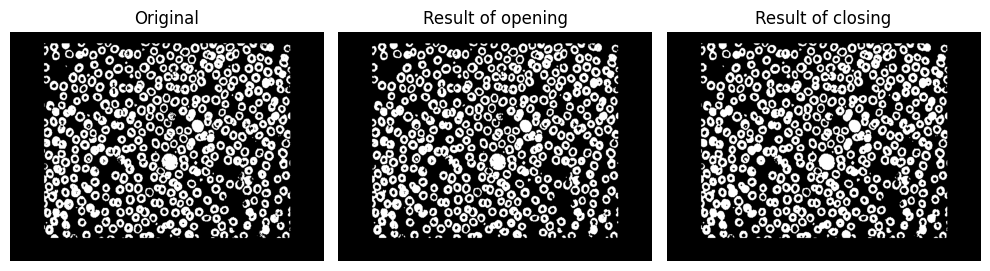

In [18]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(D, cmap="gray")
plt.axis("off")
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(D_opened, cmap="gray")
plt.axis("off")
plt.title("Result of opening")

plt.subplot(1, 3, 3)
plt.imshow(D_closed, cmap="gray")
plt.axis("off")
plt.title("Result of closing")

plt.tight_layout()

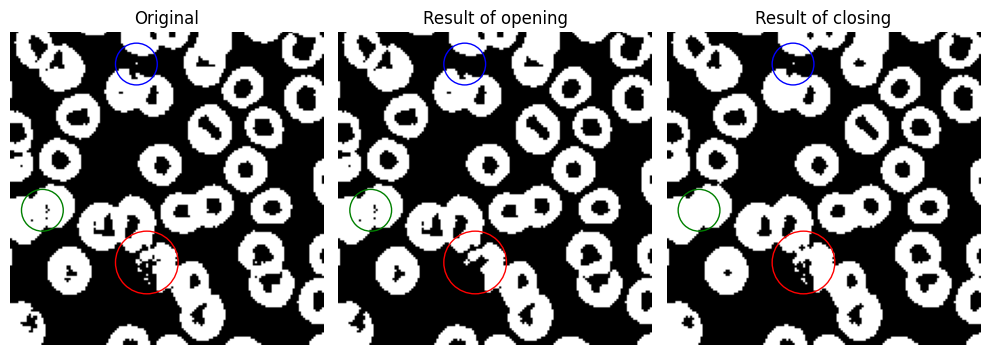

In [19]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(D[200:350, 200:350], cmap="gray")
plt.axis("off")
plt.title("Original")
plt.plot()
circle = plt.Circle((65, 110), 15, fill=False, color="red")
plt.gca().add_patch(circle)
circle = plt.Circle((15, 85), 10, fill=False, color="green")
plt.gca().add_patch(circle)
circle = plt.Circle((60, 15), 10, fill=False, color="blue")
plt.gca().add_patch(circle)

plt.subplot(1, 3, 2)
plt.imshow(D_opened[200:350, 200:350], cmap="gray")
plt.axis("off")
plt.title("Result of opening")
plt.plot()
circle = plt.Circle((65, 110), 15, fill=False, color="red")
plt.gca().add_patch(circle)
circle = plt.Circle((15, 85), 10, fill=False, color="green")
plt.gca().add_patch(circle)
circle = plt.Circle((60, 15), 10, fill=False, color="blue")
plt.gca().add_patch(circle)

plt.subplot(1, 3, 3)
plt.imshow(D_closed[200:350, 200:350], cmap="gray")
plt.axis("off")
plt.title("Result of closing")
plt.plot()
circle = plt.Circle((65, 110), 15, fill=False, color="red")
plt.gca().add_patch(circle)
circle = plt.Circle((15, 85), 10, fill=False, color="green")
plt.gca().add_patch(circle)
circle = plt.Circle((60, 15), 10, fill=False, color="blue")
plt.gca().add_patch(circle)

plt.tight_layout()

### Problem 3.1.3

In [20]:
labels_opened, num_labels_opened = label(D_opened, return_num=True, connectivity=2)
labels_closed, num_labels_closed = label(D_closed, return_num=True, connectivity=2)

Number of cells after performing opening: 369
Number of cells after performing closing: 343


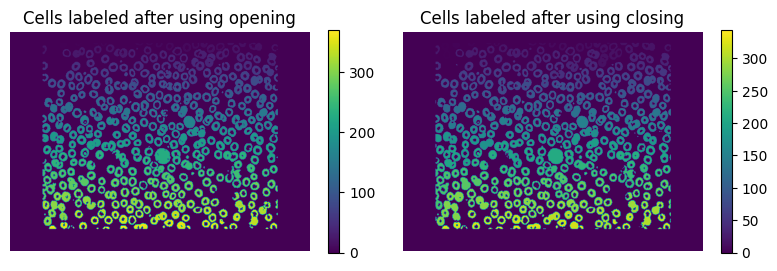

In [21]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(labels_opened)
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.title("Cells labeled after using opening")

plt.subplot(1, 2, 2)
plt.imshow(labels_closed)
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.title("Cells labeled after using closing")

plt.tight_layout()

print(f"Number of cells after performing opening: {num_labels_opened}")
print(f"Number of cells after performing closing: {num_labels_closed}")

### Problem 3.2

Number of detected coins: 11


Text(320, 310, '11')

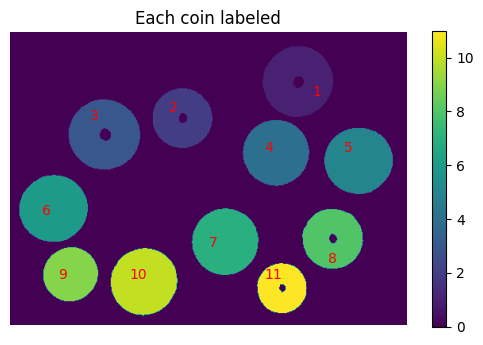

In [22]:
E = img_as_float(imread("money_bin.png"))

E_inverted = np.empty_like(E)  # initialize inverted image

for i in range(E.shape[0]):  # invert image
    for j in range(E.shape[1]):
        if E[i,j] == 0:
            E_inverted[i,j] = 1
        elif E[i,j] == 1:
            E_inverted[i,j] = 0

E_opened = opening(E_inverted, SE)  # remove noise by opening

# find connected components
labels_coins, num_labels_coins = label(E_opened, return_num=True, connectivity=2)

print(f"Number of detected coins: {num_labels_coins}")

plt.imshow(labels_coins)
plt.colorbar(shrink=0.8)
plt.axis("off")
plt.title("Each coin labeled")

plt.text(380, 80, "1", color="red")
plt.text(200, 100, "2", color="red")
plt.text(100, 110, "3", color="red")
plt.text(320, 150, "4", color="red")
plt.text(420, 150, "5", color="red")
plt.text(40, 230, "6", color="red")
plt.text(250, 270, "7", color="red")
plt.text(400, 290, "8", color="red")
plt.text(60, 310, "9", color="red")
plt.text(150, 310, "10", color="red")
plt.text(320, 310, "11", color="red")


In [23]:
# compute areas
five_kr_area = len(labels_coins[labels_coins==3])
twenty_kr_area = len(labels_coins[labels_coins==6])
two_kr_area = len(labels_coins[labels_coins==2])
one_kr_area = len(labels_coins[labels_coins==11])
fifty_øre_area = len(labels_coins[labels_coins==9])

# save areas in arrays
area_reference_coins = np.array([five_kr_area, twenty_kr_area, two_kr_area, one_kr_area, fifty_øre_area])

# save what area correspond to which type of coin
ID_reference_coins = ["5 kr", "20 kr", "2 kr", "1 kr", "50 øre"]

# Assign a value in kr to each type of coin
value_reference_coins = np.array([5, 20, 2, 1, 0.5])

print(f"Area of 5 kr: {five_kr_area}")
print(f"Area of 2 kr: {two_kr_area}")
print(f"Area of 1 kr: {one_kr_area}")
print(f"Area of 20 kr: {twenty_kr_area}")
print(f"Area of 50 øre: {fifty_øre_area}")

Area of 5 kr: 6035
Area of 2 kr: 4324
Area of 1 kr: 3021
Area of 20 kr: 5655
Area of 50 øre: 3675


In [24]:
area_coin = np.zeros(num_labels_coins)  # initialize

for i in range(num_labels_coins):  # measure area of each coin
    area_coin[i] = len(labels_coins[labels_coins==i+1])

# compute difference between measured area and area of each reference coin
diff = np.abs(area_coin[:, np.newaxis] - area_reference_coins[np.newaxis, :])

find_coin_ID = np.argmin(diff, axis=1)  # determine what reference area is closest

for i, ID in enumerate(find_coin_ID):
    print(f"Coin number {i+1} is a {ID_reference_coins[ID]}")

Coin number 1 is a 5 kr
Coin number 2 is a 2 kr
Coin number 3 is a 5 kr
Coin number 4 is a 20 kr
Coin number 5 is a 20 kr
Coin number 6 is a 20 kr
Coin number 7 is a 20 kr
Coin number 8 is a 2 kr
Coin number 9 is a 50 øre
Coin number 10 is a 20 kr
Coin number 11 is a 1 kr


Text(320, 310, '1 kr')

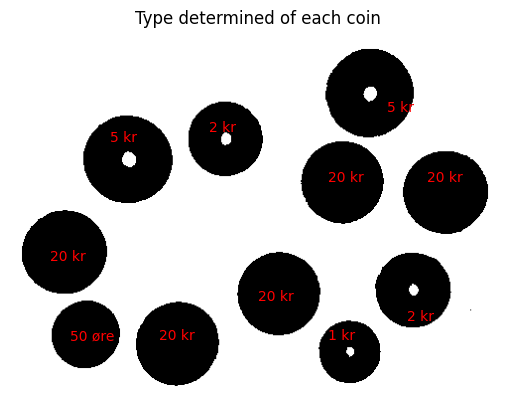

In [25]:
plt.imshow(E, cmap="gray")
plt.axis("off")
plt.title("Type determined of each coin")

plt.text(380, 80, f"{ID_reference_coins[find_coin_ID[0]]}", color="red")
plt.text(200, 100, f"{ID_reference_coins[find_coin_ID[1]]}", color="red")
plt.text(100, 110, f"{ID_reference_coins[find_coin_ID[2]]}", color="red")
plt.text(320, 150, f"{ID_reference_coins[find_coin_ID[3]]}", color="red")
plt.text(420, 150, f"{ID_reference_coins[find_coin_ID[4]]}", color="red")
plt.text(40, 230, f"{ID_reference_coins[find_coin_ID[5]]}", color="red")
plt.text(250, 270, f"{ID_reference_coins[find_coin_ID[6]]}", color="red")
plt.text(400, 290, f"{ID_reference_coins[find_coin_ID[7]]}", color="red")
plt.text(60, 310, f"{ID_reference_coins[find_coin_ID[8]]}", color="red")
plt.text(150, 310, f"{ID_reference_coins[find_coin_ID[9]]}", color="red")
plt.text(320, 310, f"{ID_reference_coins[find_coin_ID[10]]}", color="red")

In [26]:
total_amount = 0  # initialize

for ID in find_coin_ID:  # sum up coin values
    total_amount += value_reference_coins[ID]

print(f"The total amount of money is {total_amount} kr")

The total amount of money is 115.5 kr


### Problem 3.3

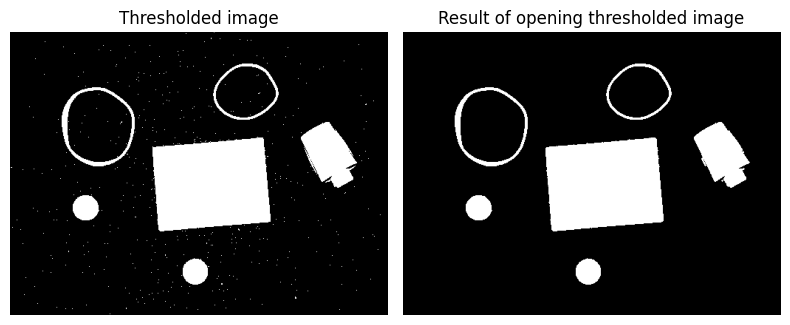

In [27]:
C_thresholded_opened = binary_opening(C_thresholded, disk(1))

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(C_thresholded, cmap="gray")
plt.axis("off")
plt.title("Thresholded image")

plt.subplot(1,2,2)
plt.imshow(C_thresholded_opened, cmap="gray")
plt.axis("off")
plt.title("Result of opening thresholded image")

plt.tight_layout()

## 4. Inspecting Spectograms

### Problem 4.1

In [28]:
soundbyte, soundbyte_samplerate = sf.read("progression.wav")

Window size: 22050


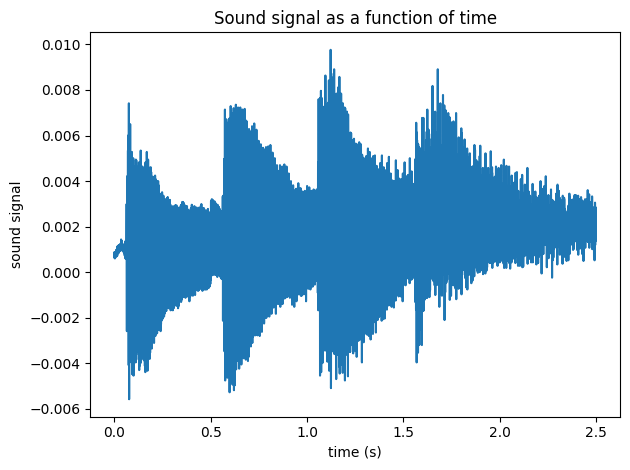

In [29]:
time = np.linspace(0, len(soundbyte)/soundbyte_samplerate, len(soundbyte))

plt.plot(time, soundbyte)
plt.xlabel("time (s)")
plt.ylabel("sound signal")
plt.title("Sound signal as a function of time")
plt.tight_layout()

window = np.min(np.where(time>=0.5))
print(f"Window size: {window}")

In [30]:
def spectrogram(signal, samplerate, window_size, stride):

    num_windows = int((len(signal) - window_size) / stride) + 1  # compute number of windows

    spectrogram_data = np.empty((window_size, num_windows))  # initialize spectrogram

    dt = stride/samplerate
    time = np.arange(num_windows, dtype=float) * dt  # generate time axis

    freq = fftshift(fftfreq(window_size, 1/samplerate))  # generate frequency axis

    # compute spectrogram
    for i in range(num_windows):
        segment = signal[i*stride:i*stride+window_size]  # select current segment
        fft_segment = fftshift(fft(segment))  # compute Fourier transform
        power_spec_segment = np.abs(fft_segment)  # compute power spectrum
        spectrogram_data[:,i] = power_spec_segment  # save current step

    return spectrogram_data, time, freq

In [31]:
s, t, f = spectrogram(soundbyte, soundbyte_samplerate, window_size=window, stride=100)

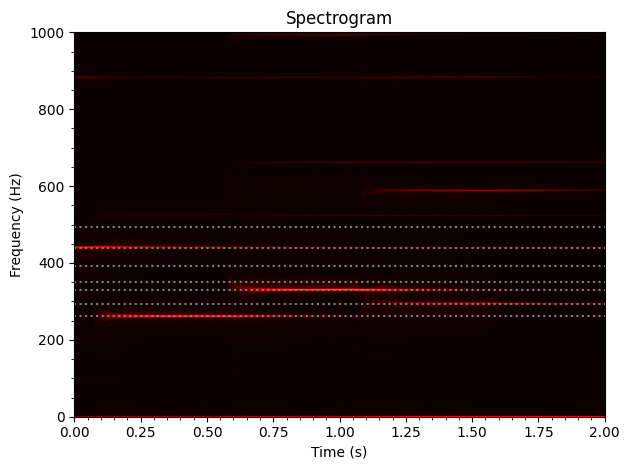

In [32]:
freqs = np.array([261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88])
freq_ID = ["C", "D", "E", "F", "G", "A", "B"]

plt.imshow(s, origin='lower', aspect="auto", extent=[t[0], t[-1], f[0], f[-1]], cmap="hot")
plt.ylim(0, 1000)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram")
plt.minorticks_on()

plt.hlines(freqs, t[0], t[-1], colors="gray", linestyles="dotted")
plt.tight_layout()